<a href="https://colab.research.google.com/github/MichaelHamonangan/Analisis-Trend-Pariwisata-di-Yogyakarta-melalui-Media-Sosial/blob/master/KP_Michael_Dika_UGM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ANALISIS TREND PARIWISATA DI YOGYAKARTA MELALUI MEDIA SOSIAL**



> Pariwisata merupakan salah satu sektor yang sangat penting dalam perekonomian Indonesia, terutama di Yogyakarta yang terkenal dengan kekayaan alam dan budayanya. Saat ini, media sosial menjadi salah satu sarana utama untuk mempromosikan destinasi pariwisata, termasuk di Yogyakarta. Oleh karena itu, analisis trend pariwisata di Yogyakarta melalui media sosial sangat penting untuk memahami bagaimana wisatawan mengakses informasi tentang destinasi wisata dan bagaimana tren pariwisata di Yogyakarta seiring dengan penggunaan media sosial yang semakin meluas.

> Dalam projek ini, akan dilakukan pengkajian terkait  analisis trend pariwisata di Yogyakarta melalui media sosial dengan menggunakan metode analisis tren dan analisis sentimen. Analisis tren akan digunakan untuk memahami bagaimana tren pariwisata di Yogyakarta pada tahun 2022. Sementara itu, analisis sentimen akan digunakan untuk memahami pandangan wisatawan tentang destinasi wisata di Yogyakarta yang terpapar melalui media sosial.





###**1. Melakukan *Import Library*** 



> Jalankan kode berikut untuk mengimport library yang akan digunakan dalam proses kali ini



In [ ]:
import gc
import re
import string
import spacy
import pandas as pd
import numpy as np
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt 
%matplotlib inline     
sns.set(color_codes=True)
from collections import Counter

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install Sastrawi
!pip install transformers
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoConfig, TextClassificationPipeline

###**2. Melakukan *Load* dataset ke dataframe**

In [ ]:
# Dataframe untuk tweets terkait jogja secara umum
dfjogja = pd.read_csv("https://raw.githubusercontent.com/MichaelHamonangan/Analisis-Trend-Pariwisata-di-Yogyakarta-melalui-Media-Sosial/master/Dataset/jogja_yogyakarta_twt.csv")

# Dataframe untuk tweets terkait wisata jogja
dfjogjawis = pd.read_csv("https://raw.githubusercontent.com/MichaelHamonangan/Analisis-Trend-Pariwisata-di-Yogyakarta-melalui-Media-Sosial/master/Dataset/wisatajogja_twt.csv")

# Dataframe untuk tweets dengan tag untuk tiap-tiap nama wisata yang ada di jogja kota saja
dfwisata = pd.read_csv("https://raw.githubusercontent.com/MichaelHamonangan/Analisis-Trend-Pariwisata-di-Yogyakarta-melalui-Media-Sosial/master/Dataset/twtWisataKota.csv")


> Melakukan Rename nama kolom ke bentuk standar



In [ ]:
dfjogja = dfjogja.rename(columns={'ID': 'id', 'User': 'user', 'Date Created': 'date_created', 'Number of Likes': 'likes', 'Source of Tweet': 'source', 'Tweet': 'tweet'})
dfjogjawis = dfjogjawis.rename(columns={'ID': 'id', 'User': 'user', 'Date Created': 'date_created', 'Number of Likes': 'likes', 'Source of Tweet': 'source', 'Tweet': 'tweet'})
dfwisata = dfwisata.rename(columns={'ID': 'id', 'User': 'user', 'Date Created': 'date_created', 'Number of Likes': 'likes', 'Source of Tweet': 'source', 'Tweet': 'tweet', 'Tagname': 'tag'})


> Penyesuaian format untuk *Datetime* 


In [ ]:
#Format waktu agar hanya sensitif sampai jam saja 
dfjogja['date_created'] = pd.to_datetime(dfjogja['date_created'])
dfjogja['date_time'] = dfjogja['date_created'].apply(lambda x: x.replace(minute=0, second=0))
dfjogja.drop(['date_created'], axis=1, inplace=True)

dfjogjawis['date_created'] = pd.to_datetime(dfjogjawis['date_created'])
dfjogjawis['date_time'] = dfjogjawis['date_created'].apply(lambda x: x.replace(minute=0, second=0))
dfjogjawis.drop(['date_created'], axis=1, inplace=True)

dfwisata['date_created'] = pd.to_datetime(dfwisata['date_created'])
dfwisata['date_time'] = dfwisata['date_created'].apply(lambda x: x.replace(minute=0, second=0))
dfwisata.drop(['date_created'], axis=1, inplace=True)

In [ ]:
dfjogja.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451838 entries, 0 to 451837
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype              
---  ------     --------------   -----              
 0   id         451838 non-null  int64              
 1   user       451838 non-null  object             
 2   likes      451838 non-null  int64              
 3   source     451838 non-null  object             
 4   tweet      451838 non-null  object             
 5   date_time  451838 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(2), object(3)
memory usage: 20.7+ MB


In [ ]:
dfjogja.tail(10)

,id,user,likes,source,tweet,date_time
451828,451828,polresjogja,38,Twitter Web App,Polsek Gedongtengen Tangkap Empat Pelaku Penge...,2022-12-07 03:00:00+00:00
451829,451829,lokerjog,0,Loker Jogja ID,LOKER JOGJA TERBARU: Staff Marketplace di CV. ...,2022-12-07 03:00:00+00:00
451830,451830,GuruYogyakarta,0,Instagram,Baru saja mengirim foto @ Yogyakarta https://t...,2022-12-07 03:00:00+00:00
451831,451831,ahlik3umum_,0,Twitter Web App,Dokumentasi Pembinaan Calon Ahli K3 Umum Serti...,2022-12-07 03:00:00+00:00
451832,451832,disporaparjtg,8,Twitter for Android,Rakor Pokja Program pembangunan pariwisata ter...,2022-12-07 03:00:00+00:00
451833,451833,mr_DT_Yanuarsa,0,Instagram,Kata orang panas.. Kata gue berkah.. @ Titik N...,2022-12-07 03:00:00+00:00
451834,451834,Alissa_Butik,0,Instagram,Baru saja mengirim foto @ Special Region of Yo...,2022-12-07 03:00:00+00:00
451835,451835,KAI121,0,KAI121v2,@jlc147 Selamat pagi Kak. Bila yang dimaksud K...,2022-12-07 03:00:00+00:00
451836,451836,kompascom,0,dlvr.it,PO Tami Jaya menambah bus baru untuk armadanya...,2022-12-07 03:00:00+00:00
451837,451837,Kemenag_DIY,0,Twitter for iPhone,Kabag Tata Usaha Muntolib didampingi Kabid Uru...,2022-12-07 03:00:00+00:00


In [ ]:
dfjogjawis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19585 entries, 0 to 19584
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   id         19585 non-null  int64              
 1   user       19585 non-null  object             
 2   likes      19585 non-null  int64              
 3   source     19585 non-null  object             
 4   tweet      19585 non-null  object             
 5   date_time  19585 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(2), object(3)
memory usage: 918.2+ KB


In [ ]:
dfjogjawis.tail(10)

,id,user,likes,source,tweet,date_time
19575,19575,infobmkgyia,0,Twitter Web App,Berikut kami sampaikan Prakiraan Cuaca Lokasi ...,2022-12-02 03:00:00+00:00
19576,19576,BikinLaparMata,0,twittbot.net,Yogyakarta terkenal dgn wisata kuliner yg mura...,2022-12-02 02:00:00+00:00
19577,19577,wisataapp,4,Twitter for iPhone,Ada berbagai tempat wisata yang bisa Anda kunj...,2022-12-01 14:00:00+00:00
19578,19578,rkrijuara,6,Twitter Web App,"Best 5 Oto: Bertandang ke Toyota xEV Center, @...",2022-12-01 12:00:00+00:00
19579,19579,fajarposmedia,0,dlvr.it,HeHa Sky View Spot Nongkorong Keren di Jogja: ...,2022-12-01 11:00:00+00:00
19580,19580,merrie_red,5,Twitter for Android,@waspkick @seper_sepuluh Sepertinya tidak. Yog...,2022-12-01 06:00:00+00:00
19581,19581,SinergiPapers,0,Twitter Web App,Wisata Yogyakarta yang Selalu Menjadi Tren di ...,2022-12-01 05:00:00+00:00
19582,19582,infobmkgyia,1,Twitter Web App,Berikut kami sampaikan Prakiraan Cuaca Lokasi ...,2022-12-01 03:00:00+00:00
19583,19583,mekanisasiKP,0,Twitter Web App,"Selain sebagai Kp. Pramuka, Bromonilan juga me...",2022-12-01 01:00:00+00:00
19584,19584,mitabusjogja,0,Twitter for Android,Masih ready ya kak\nMedium Bus Pariwisata untu...,2022-12-01 00:00:00+00:00


In [ ]:
dfwisata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35368 entries, 0 to 35367
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   id         35368 non-null  int64              
 1   user       35368 non-null  object             
 2   likes      35368 non-null  int64              
 3   source     35368 non-null  object             
 4   tweet      35368 non-null  object             
 5   tag        35368 non-null  object             
 6   date_time  35368 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 1.9+ MB


In [ ]:
dfwisata.tail(10)

,id,user,likes,source,tweet,tag,date_time
35358,35359,rhdinsky,0,Twitter for Android,@hasseennnn yg samping has arah ke tempat artjog,Artjog,2022-01-11 05:00:00+00:00
35359,35360,louisdesanc,0,Twitter for Android,Bagus karyanya kak g4lih di artjog kmaren. Kok...,Artjog,2022-01-10 15:00:00+00:00
35360,35361,waterainluv,5,Twitter for Android,@Yupiboli @convomf Ini karyanya bisa dipajang ...,Artjog,2022-01-08 05:00:00+00:00
35361,35362,NzulR,0,Twitter Web App,@artjog 2022 ada lagi gak ya,Artjog,2022-01-08 01:00:00+00:00
35362,35363,dinxxx8h,0,Twitter Web App,@ngalamfess Artjog nder tapi di jogja sih 😅,Artjog,2022-01-07 13:00:00+00:00
35363,35364,sorr_yy,0,Twitter for Android,@Akhlis_M @itskinda_dita @wikan_bagas @sinemas...,Artjog,2022-01-05 13:00:00+00:00
35364,35365,schwittlick_,1,Twitter Web App,@claracxw @nft_asia Maybe you know @ignatianil...,Artjog,2022-01-03 09:00:00+00:00
35365,35366,sasukemikir,0,Twitter Web App,tbtb kangen ke jogja naik kereta terus ke artj...,Artjog,2022-01-01 13:00:00+00:00
35366,35367,arizalp_,0,Twitter for iPhone,@chocolat0zze @sinemasisifus @salsaistya Ayo k...,Artjog,2022-01-01 11:00:00+00:00
35367,35368,tershanjung13,4,Twitter for Android,cok iling pas nng artjog koncoe sigit ngongkon...,Artjog,2022-01-01 09:00:00+00:00


###**3. Dataframe *Preprocessing***

In [ ]:
print(dfjogja.shape)
print(dfjogjawis.shape)
print(dfwisata.shape)

(451838, 6)
(19585, 6)
(35368, 7)


> **Row Preprocessing**





*   Menghapus Baris yang bersifat duplikat berdasar atribut user, tweet, and date.



In [ ]:
# Membuat kolom *dummy* yaitu date agar duplikasi yang dihapus adalah tweet yang sama yang dikirim oleh user yang sama dalam satu hari

dfjogja['date'] = pd.to_datetime(dfjogja['date_time']).dt.date
dfjogjawis['date'] = pd.to_datetime(dfjogjawis['date_time']).dt.date
dfwisata['date'] = pd.to_datetime(dfwisata['date_time']).dt.date

In [ ]:
print("number of duplicate rows dfjogja: ", dfjogja[dfjogja.duplicated(['user', 'tweet','date'])].shape)
dfjogja = dfjogja.drop_duplicates(['user', 'tweet','date'])

print("number of duplicate rows dfjogjawis: ", dfjogjawis[dfjogjawis.duplicated(['user', 'tweet','date'])].shape)
dfjojgawis = dfjogjawis.drop_duplicates(['user', 'tweet','date'])

print("number of duplicate rows dfwisata: ", dfwisata[dfwisata.duplicated(['user', 'tweet','date'])].shape)
dfwisata = dfwisata.drop_duplicates(['user', 'tweet','date'])

# Menghapus lagi kolom date yang dipakai sebagai dummy atribut
dfjogja.drop(['date'], axis=1, inplace=True)
dfjogjawis.drop(['date'], axis=1, inplace=True)
dfwisata.drop(['date'], axis=1, inplace=True)

number of duplicate rows dfjogja:  (13292, 7)
number of duplicate rows dfjogjawis:  (2620, 7)
number of duplicate rows dfwisata:  (1792, 8)


<ipython-input-13-6a64c1ccc3ba>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfjogja.drop(['date'], axis=1, inplace=True)
<ipython-input-13-6a64c1ccc3ba>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfwisata.drop(['date'], axis=1, inplace=True)


*   Menghapus baris yang memiliki nilai Null (jika ada)

In [ ]:
dfjogja.isnull().sum()

id           0
user         0
likes        0
source       0
tweet        0
date_time    0
dtype: int64

In [ ]:
dfjogjawis.isnull().sum()

id           0
user         0
likes        0
source       0
tweet        0
date_time    0
dtype: int64

In [ ]:
dfwisata.isnull().sum()

id           0
user         0
likes        0
source       0
tweet        0
tag          0
date_time    0
dtype: int64


> **Column Preprocessing**


*   Menghapus atribut **user** untuk semua dataframe karena identitas tidak mempengaruhi hasil

In [ ]:
dfjogja.drop(['user'], axis=1, inplace=True)
dfjogjawis.drop(['user'], axis=1, inplace=True)
dfwisata.drop(['user'], axis=1, inplace=True)

In [ ]:
dfjogja.tail(10)

,id,likes,source,tweet,date_time
451828,451828,38,Twitter Web App,Polsek Gedongtengen Tangkap Empat Pelaku Penge...,2022-12-07 03:00:00+00:00
451829,451829,0,Loker Jogja ID,LOKER JOGJA TERBARU: Staff Marketplace di CV. ...,2022-12-07 03:00:00+00:00
451830,451830,0,Instagram,Baru saja mengirim foto @ Yogyakarta https://t...,2022-12-07 03:00:00+00:00
451831,451831,0,Twitter Web App,Dokumentasi Pembinaan Calon Ahli K3 Umum Serti...,2022-12-07 03:00:00+00:00
451832,451832,8,Twitter for Android,Rakor Pokja Program pembangunan pariwisata ter...,2022-12-07 03:00:00+00:00
451833,451833,0,Instagram,Kata orang panas.. Kata gue berkah.. @ Titik N...,2022-12-07 03:00:00+00:00
451834,451834,0,Instagram,Baru saja mengirim foto @ Special Region of Yo...,2022-12-07 03:00:00+00:00
451835,451835,0,KAI121v2,@jlc147 Selamat pagi Kak. Bila yang dimaksud K...,2022-12-07 03:00:00+00:00
451836,451836,0,dlvr.it,PO Tami Jaya menambah bus baru untuk armadanya...,2022-12-07 03:00:00+00:00
451837,451837,0,Twitter for iPhone,Kabag Tata Usaha Muntolib didampingi Kabid Uru...,2022-12-07 03:00:00+00:00


In [ ]:
dfjogjawis.tail(10)

,id,likes,source,tweet,date_time
19575,19575,0,Twitter Web App,Berikut kami sampaikan Prakiraan Cuaca Lokasi ...,2022-12-02 03:00:00+00:00
19576,19576,0,twittbot.net,Yogyakarta terkenal dgn wisata kuliner yg mura...,2022-12-02 02:00:00+00:00
19577,19577,4,Twitter for iPhone,Ada berbagai tempat wisata yang bisa Anda kunj...,2022-12-01 14:00:00+00:00
19578,19578,6,Twitter Web App,"Best 5 Oto: Bertandang ke Toyota xEV Center, @...",2022-12-01 12:00:00+00:00
19579,19579,0,dlvr.it,HeHa Sky View Spot Nongkorong Keren di Jogja: ...,2022-12-01 11:00:00+00:00
19580,19580,5,Twitter for Android,@waspkick @seper_sepuluh Sepertinya tidak. Yog...,2022-12-01 06:00:00+00:00
19581,19581,0,Twitter Web App,Wisata Yogyakarta yang Selalu Menjadi Tren di ...,2022-12-01 05:00:00+00:00
19582,19582,1,Twitter Web App,Berikut kami sampaikan Prakiraan Cuaca Lokasi ...,2022-12-01 03:00:00+00:00
19583,19583,0,Twitter Web App,"Selain sebagai Kp. Pramuka, Bromonilan juga me...",2022-12-01 01:00:00+00:00
19584,19584,0,Twitter for Android,Masih ready ya kak\nMedium Bus Pariwisata untu...,2022-12-01 00:00:00+00:00


In [ ]:
dfwisata.tail(10)

,id,likes,source,tweet,tag,date_time
35358,35359,0,Twitter for Android,@hasseennnn yg samping has arah ke tempat artjog,Artjog,2022-01-11 05:00:00+00:00
35359,35360,0,Twitter for Android,Bagus karyanya kak g4lih di artjog kmaren. Kok...,Artjog,2022-01-10 15:00:00+00:00
35360,35361,5,Twitter for Android,@Yupiboli @convomf Ini karyanya bisa dipajang ...,Artjog,2022-01-08 05:00:00+00:00
35361,35362,0,Twitter Web App,@artjog 2022 ada lagi gak ya,Artjog,2022-01-08 01:00:00+00:00
35362,35363,0,Twitter Web App,@ngalamfess Artjog nder tapi di jogja sih 😅,Artjog,2022-01-07 13:00:00+00:00
35363,35364,0,Twitter for Android,@Akhlis_M @itskinda_dita @wikan_bagas @sinemas...,Artjog,2022-01-05 13:00:00+00:00
35364,35365,1,Twitter Web App,@claracxw @nft_asia Maybe you know @ignatianil...,Artjog,2022-01-03 09:00:00+00:00
35365,35366,0,Twitter Web App,tbtb kangen ke jogja naik kereta terus ke artj...,Artjog,2022-01-01 13:00:00+00:00
35366,35367,0,Twitter for iPhone,@chocolat0zze @sinemasisifus @salsaistya Ayo k...,Artjog,2022-01-01 11:00:00+00:00
35367,35368,4,Twitter for Android,cok iling pas nng artjog koncoe sigit ngongkon...,Artjog,2022-01-01 09:00:00+00:00


In [ ]:
print(dfjogja.shape)
print(dfjogjawis.shape)
print(dfwisata.shape)

(438546, 5)
(19585, 5)
(33576, 6)


###**4. Case Folding**



> Akan dilakukan cleaning terhadap data tweets yang meliputi :



*   Membuat teks dalam huruf kecil semua (mengganti huruf kapital)
*   Menghilangkan teks yang didalamkurungi
*   Menghilangkan teks yang berupa link
*   Menghilangkan tanda baca
*   Menghilangkan kata yang mengandung angka

In [ ]:
def clean_text(text):
    
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
dfjogja['tweet'] = dfjogja['tweet'].apply(lambda x:clean_text(x))
dfjogjawis['tweet'] = dfjogjawis['tweet'].apply(lambda x:clean_text(x))
dfwisata['tweet'] = dfwisata['tweet'].apply(lambda x:clean_text(x))



> **Cleaning Stopwords**



In [ ]:
# Melakukan tokenisasi tiap kata untuk tweet dan menyimpannya ke kolom baru yang kita namakan temp_list

dfjogja['temp_list'] = dfjogja['tweet'].apply(lambda x:str(x).split())
dfjogjawis['temp_list'] = dfjogjawis['tweet'].apply(lambda x:str(x).split())
dfwisata['temp_list'] = dfwisata['tweet'].apply(lambda x:str(x).split())

Contoh untuk most common word pada dataframe jogjawis

In [ ]:
print("Jogjawis".center(24," "))
top = Counter([item for sublist in dfjogjawis['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

        Jogjawis        


,Common_words,count
0,wisata,20283
1,jogja,16343
2,di,8852
3,yogyakarta,4187
4,dan,3932
5,yang,3482
6,tempat,3425
7,ke,3367
8,traveling,3212
9,alam,3045


Kata-kata diatas masih dipenuhi dengan kata yang disebut 'stopwords', yaitu kata yang seharusnya diabaikan dalam pemrosesan bahasa alami karena tidak memiliki nilai informasi apapun terhadap sentimen analisis kita nantinya. Contohnya adalah di, dan, yang, ini, dst

In [ ]:
indonesian_stopwords = stopwords.words('indonesian')
indonesian_stopwords.append('yg')                                           #karena yg adalah tulisan gaul yang artinya yang
print(len(indonesian_stopwords), "stopwords:", indonesian_stopwords)

def remove_stopword(x):
    return [y for y in x if y not in indonesian_stopwords]

759 stopwords: ['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara', 'antaranya', 'apa', 'apaan', 'apabila', 'apakah', 'apalagi', 'apatah', 'artinya', 'asal', 'asalkan', 'atas', 'atau', 'ataukah', 'ataupun', 'awal', 'awalnya', 'bagai', 'bagaikan', 'bagaimana', 'bagaimanakah', 'bagaimanapun', 'bagi', 'bagian', 'bahkan', 'bahwa', 'bahwasanya', 'baik', 'bakal', 'bakalan', 'balik', 'banyak', 'bapak', 'baru', 'bawah', 'beberapa', 'begini', 'beginian', 'beginikah', 'beginilah', 'begitu', 'begitukah', 'begitulah', 'begitupun', 'bekerja', 'belakang', 'belakangan', 'belum', 'belumlah', 'benar', 'benarkah', 'benarlah', 'berada', 'berakhir', 'berakhirlah', 'berakhirnya', 'berapa', 'berapakah', 'berapalah', 'berapapun', 'berarti', 'berawal', 'berbagai', 'berdatangan', 'beri', 'berikan', 'berikut', 'berikutnya', 'berjumlah', 'berkali-kali', 'berkata', 'berkehendak',

In [ ]:
dfjogja['temp_list'] = dfjogja['temp_list'].apply(lambda x:remove_stopword(x))
dfjogjawis['temp_list'] = dfjogjawis['temp_list'].apply(lambda x:remove_stopword(x))
dfwisata['temp_list'] = dfwisata['temp_list'].apply(lambda x:remove_stopword(x))

* Hasil most common word word untuk ketiga dataframe

In [ ]:
print("Dataframe Jogja".center(24," "))
top = Counter([item for sublist in dfjogja['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Greens')

    Dataframe Jogja     


,Common_words,count
0,jogja,277907
1,yogyakarta,132520
2,dom,33080
3,ya,25425
4,loker,20815
5,istimewa,20446
6,aja,18823
7,ga,18215
8,daerah,16677
9,kota,14915


In [ ]:
dfjogja.tail(5)

,id,likes,source,tweet,date_time,temp_list
451833,451833,0,Instagram,kata orang panas kata gue berkah titik nol km...,2022-12-07 03:00:00+00:00,"[orang, panas, gue, berkah, titik, nol, km, yo..."
451834,451834,0,Instagram,baru saja mengirim foto special region of yog...,2022-12-07 03:00:00+00:00,"[mengirim, foto, special, region, of, yogyakarta]"
451835,451835,0,KAI121v2,selamat pagi kak bila yang dimaksud kakak sud...,2022-12-07 03:00:00+00:00,"[selamat, pagi, kak, kakak, memiliki, tiket, k..."
451836,451836,0,dlvr.it,po tami jaya menambah bus baru untuk armadanya...,2022-12-07 03:00:00+00:00,"[po, tami, jaya, menambah, bus, armadanya, mel..."
451837,451837,0,Twitter for iPhone,kabag tata usaha muntolib didampingi kabid uru...,2022-12-07 03:00:00+00:00,"[kabag, tata, usaha, muntolib, didampingi, kab..."


In [ ]:
print("Dataframe Jogjawis".center(24," "))
top = Counter([item for sublist in dfjogjawis['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

   Dataframe Jogjawis   


,Common_words,count
0,wisata,20283
1,jogja,16343
2,yogyakarta,4187
3,traveling,3212
4,alam,3045
5,guide,2582
6,jogjacitytour,2555
7,jelajah,1870
8,curug,1723
9,diy,1564


In [ ]:
dfjogjawis.tail(5)

,id,likes,source,tweet,date_time,temp_list
19580,19580,5,Twitter for Android,waspkick sepersepuluh sepertinya tidak yogyaka...,2022-12-01 06:00:00+00:00,"[waspkick, sepersepuluh, yogyakarta, msh, bert..."
19581,19581,0,Twitter Web App,wisata yogyakarta yang selalu menjadi tren di ...,2022-12-01 05:00:00+00:00,"[wisata, yogyakarta, tren, kalangan, wisatawan]"
19582,19582,1,Twitter Web App,berikut kami sampaikan prakiraan cuaca lokasi ...,2022-12-01 03:00:00+00:00,"[prakiraan, cuaca, lokasi, wisata, lereng, mer..."
19583,19583,0,Twitter Web App,selain sebagai kp pramuka bromonilan juga meru...,2022-12-01 01:00:00+00:00,"[kp, pramuka, bromonilan, salah, desa, wisata,..."
19584,19584,0,Twitter for Android,masih ready ya kakmedium bus pariwisata untuk ...,2022-12-01 00:00:00+00:00,"[ready, ya, kakmedium, bus, pariwisata, keperl..."


In [ ]:
print("Dataframe Wisata".center(24," "))
top = Counter([item for sublist in dfwisata['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Reds')

    Dataframe Wisata    


,Common_words,count
0,malioboro,9976
1,tamansari,5530
2,artjog,4977
3,taman,4623
4,sari,4199
5,pasar,3868
6,jogja,3859
7,kembang,3292
8,museum,2456
9,jalan,2411


In [ ]:
dfwisata.tail(5)

,id,likes,source,tweet,tag,date_time,temp_list
35363,35364,0,Twitter for Android,akhlism itskindadita wikanbagas sinemasisifus ...,Artjog,2022-01-05 13:00:00+00:00,"[akhlism, itskindadita, wikanbagas, sinemasisi..."
35364,35365,1,Twitter Web App,claracxw nftasia maybe you know ignatianilu fr...,Artjog,2022-01-03 09:00:00+00:00,"[claracxw, nftasia, maybe, you, know, ignatian..."
35365,35366,0,Twitter Web App,tbtb kangen ke jogja naik kereta terus ke artj...,Artjog,2022-01-01 13:00:00+00:00,"[tbtb, kangen, jogja, kereta, artjog, nonton, ..."
35366,35367,0,Twitter for iPhone,sinemasisifus salsaistya ayo ke artjog lagi😁,Artjog,2022-01-01 11:00:00+00:00,"[sinemasisifus, salsaistya, ayo, artjog, lagi😁]"
35367,35368,4,Twitter for Android,cok iling pas nng artjog koncoe sigit ngongkon...,Artjog,2022-01-01 09:00:00+00:00,"[cok, iling, pas, nng, artjog, koncoe, sigit, ..."


###**5. Visualization**



> Dari dataframe *jogja* dan *jogjawis*, bisa kita lihat bahwa karena data tidak spesifik dan cukup luas cakupannya, maka kita akan mengenalkan tipe wisata yang akan menjadi 'tag' dari data-data tersebut



In [ ]:
#List untuk daftar keyword
listWisata = ['gunung', 'pantai', 'danau', 'hutan', 'taman', 'air terjun', 'goa', 'bukit', 'lembah', 'kebun', 'taman nasional',               #Wisata Alam
              'candi', 'kuil', 'museum', 'monumen', 'cagar budaya', 'cagar alam', 'benteng', 'galeri seni', 'desa wisata', 'kampung wisata'   #Wisata Sejarah dan Budaya
              'kolam renang', 'waterpark', 'kebun binatang', 'taman bermain',                                                                 #Wisata Keluarga
              'arung jeram', 'mendaki gunung', 'hiking', 'paralayang', 'surfing', 'rafting', 'camping']                                       #Wisata Petualangan


#Temp_list hanya menyimpan 1 keyword saja, maka dibuat list untuk melakukan joint pada kata berdekatan pada tiap tweet 
listCombine = [['air','terjun'], ['taman','nasional'], ['cagar','budaya'], ['cagar','alam'],
               ['galeri','seni'], ['kolam','renang'], ['kebun','binatang'], ['taman','bermain'],
               ['arung','jeram'], ['mendaki','gunung']]

In [ ]:
# Definisi fungsi untuk melakukan joint kedua kata yang berdekatan pada temp_list
def combine(List1,List2):
  for key in List1:
    bin = []
    ind = 0
    while ind<(len(List2)-1):
      temp = [List2[ind],List2[ind+1]]
      if temp == key: 
        List2.append(List2[ind]+' '+List2[ind+1])
        bin.append(List2[ind]) if List2[ind] not in bin else bin
        bin.append(List2[ind+1]) if List2[ind+1] not in bin else bin
      ind=ind+1
    for trash in bin:
      List2.remove(trash)
  return List2


# Definisi fungsi untuk mendeteksi apakah salah satu atau lebih kata pada listWisata ada dalam tweet
def tagging(List1, List2):
  temp = []
  for item in List1:
    for key in List2:
      if item == key:
        temp.append(item) if item not in temp else temp
  return temp

In [ ]:
# dfJogja
# Combine
for ind in dfjogja.index:
  dfjogja['temp_list'][ind] = combine(listCombine,dfjogja['temp_list'][ind])

# Membuat kolom baru
dfjogja['taglist'] = [[] for _ in range(len(dfjogja))]

# Tagging
for ind in dfjogja.index:
  taglist = tagging(listWisata, dfjogja['temp_list'][ind])
  if dfjogja is not None : 
    dfjogja['taglist'][ind] = taglist

<ipython-input-36-b6a49fb78666>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfjogja['temp_list'][ind] = combine(listCombine,dfjogja['temp_list'][ind])
<ipython-input-36-b6a49fb78666>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfjogja['taglist'][ind] = taglist


In [ ]:
# dfJogjawis
# Combine

for ind in dfjogjawis.index:
  dfjogjawis['temp_list'][ind] = combine(listCombine,dfjogjawis['temp_list'][ind])

# Membuat kolom baru
dfjogjawis['taglist'] = [[] for _ in range(len(dfjogjawis))]

# Tagging
for ind in dfjogjawis.index:
  taglist = tagging(listWisata, dfjogjawis['temp_list'][ind])
  if dfjogjawis is not None : 
    dfjogjawis['taglist'][ind] = taglist

<ipython-input-37-754791679a9c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfjogjawis['temp_list'][ind] = combine(listCombine,dfjogjawis['temp_list'][ind])
<ipython-input-37-754791679a9c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfjogjawis['taglist'][ind] = taglist


In [ ]:
#drop temp_list karena sudah tidak dibutuhkan

dfjogja.drop(['temp_list'], axis=1, inplace=True)
dfjogjawis.drop(['temp_list'], axis=1, inplace=True)
dfwisata.drop(['temp_list'], axis=1, inplace=True)



> Melihat visualisasi dari dataframe dfjogja dan dfjogjawis



In [ ]:
print("Dataframe Jogja".center(24," "))
top = Counter([item for sublist in dfjogja['taglist'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['new_tag','count']
temp.style.background_gradient(cmap='Greens')

    Dataframe Jogja     


,new_tag,count
0,pantai,1919
1,gunung,1659
2,taman,1224
3,museum,845
4,candi,824
5,bukit,355
6,hutan,265
7,kebun,237
8,goa,229
9,benteng,162


<Axes: title={'center': 'Top 10 tag for dataframe dfjogja'}, xlabel='new_tag'>

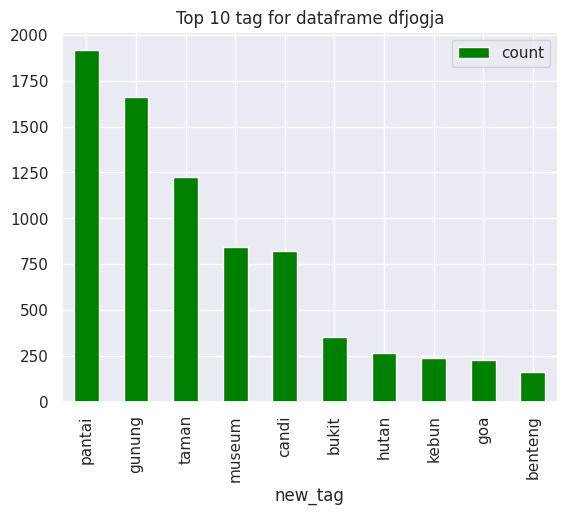

In [ ]:
temp.iloc[:10].plot.bar(x = 'new_tag', y = 'count', 
                        color = 'green', 
                        title = 'Top 10 tag for dataframe dfjogja')

In [ ]:
print("Dataframe Jogjawis".center(24," "))
top = Counter([item for sublist in dfjogjawis['taglist'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['new_tag','count']
temp.style.background_gradient(cmap='Blues')

   Dataframe Jogjawis   


,new_tag,count
0,pantai,961
1,kebun,911
2,goa,358
3,taman,354
4,gunung,340
5,candi,338
6,bukit,225
7,museum,212
8,hutan,124
9,camping,116


<Axes: title={'center': 'Top 10 tag for dataframe dfjogjawis'}, xlabel='new_tag'>

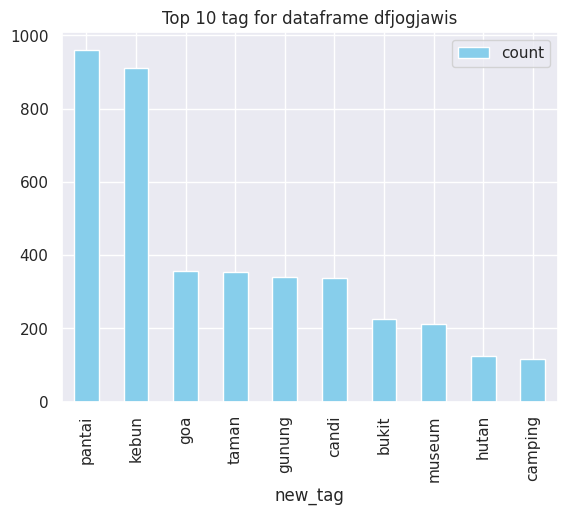

In [ ]:
temp.iloc[:10].plot.bar(x = 'new_tag', y = 'count', 
                        color = 'skyblue', 
                        title = 'Top 10 tag for dataframe dfjogjawis')



> Melihat perbandingan antara tweet yang berkaitan dengan wisata *dibandingkan dengan* tweet keseluruhan



In [ ]:
for i in range(len(listWisata)):
  a = []
  a.append(listWisata[i])
  listWisata[i] = a

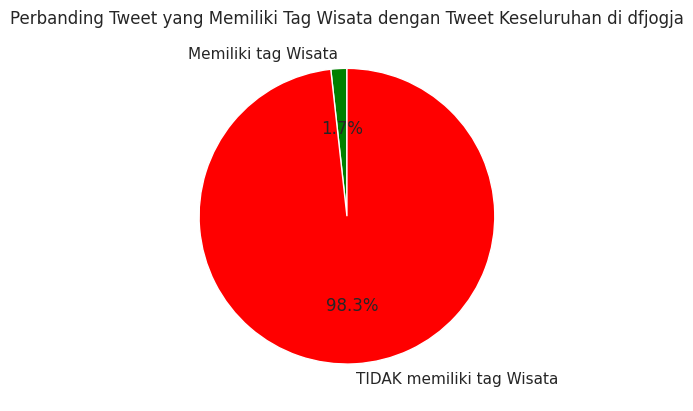

In [ ]:
isWisata = 0
isNotWisata = 0
for lst in dfjogja['taglist']:
    if not lst:
        isNotWisata += 1
    else:
        isWisata += 1

pieValues = [isWisata, isNotWisata]
labels = ['Memiliki tag Wisata', 'TIDAK memiliki tag Wisata']
colors = ['green', 'red']
plt.pie(pieValues, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Perbanding Tweet yang Memiliki Tag Wisata dengan Tweet Keseluruhan di dfjogja')
plt.show()

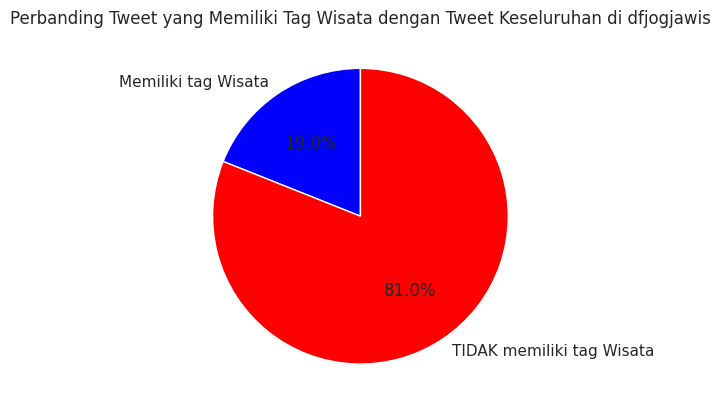

In [ ]:
isWisata = 0
isNotWisata = 0
for lst in dfjogjawis['taglist']:
    if not lst:
        isNotWisata += 1
    else:
        isWisata += 1

pieValues = [isWisata, isNotWisata]
labels = ['Memiliki tag Wisata', 'TIDAK memiliki tag Wisata']
colors = ['blue', 'red']
plt.pie(pieValues, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Perbanding Tweet yang Memiliki Tag Wisata dengan Tweet Keseluruhan di dfjogjawis')
plt.show()



> dari dataframe *dfWisata* kita bisa melihat beberapa insight yang dimiliki oleh data kita sebagai berikut



In [ ]:
# calculate the total likes of each tag value
dflikes = dfwisata.groupby(["tag"]).sum()
dflikes['likes'] = dflikes.groupby(["tag"]).mean()['likes']

dflikes.drop(['id'], axis=1, inplace=True)
dflikes = dflikes.sort_values('likes', ascending=False)

In [ ]:
dflikes.head(8)

,likes
tag,
Artjog,73503.0
Malioboro,60221.0
Gembira Loka,27882.0
Taman Sari,25826.0
Masjid Gedhe Kauman,16109.0
Pasar Kembang,7824.0
Museum Sonobudoyo,4604.0
Jogja National Museum,1819.0


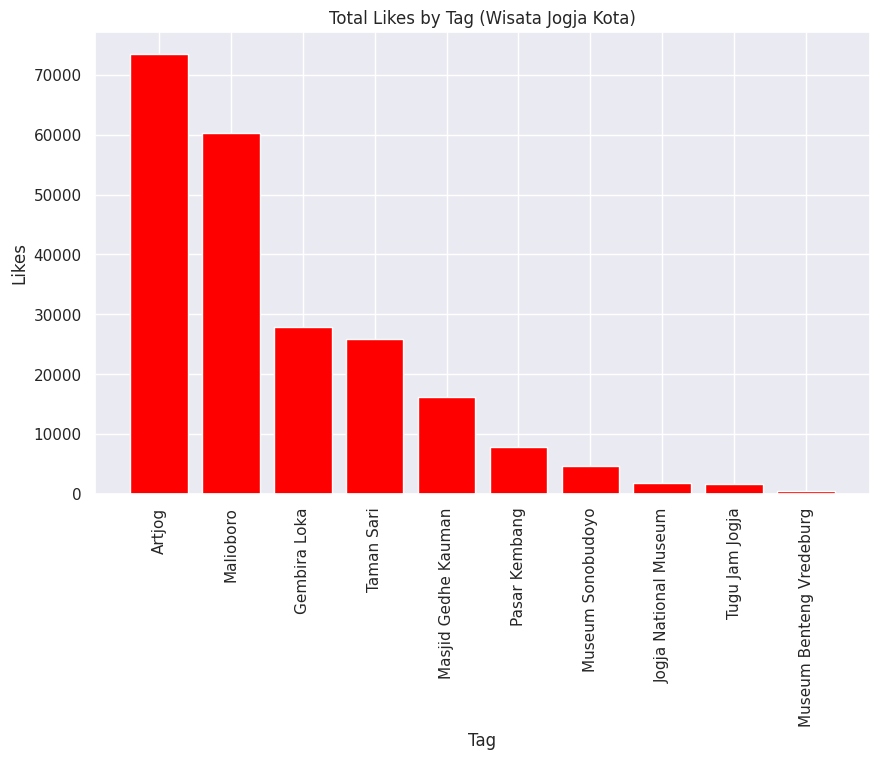

In [ ]:
# Select the top 10 tags by likes
dflikes= dflikes.nlargest(10, 'likes')

# Create a bar plot of the likes for each tag value
plt.figure(figsize=(10,6))
plt.bar(dflikes.index, dflikes['likes'], color='red')

# Set the chart title and axis labels
plt.title('Total Likes by Tag (Wisata Jogja Kota)')
plt.xlabel('Tag')
plt.ylabel('Likes')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.show()


###**6. Sentiment Analisis**




> **Sentimen dengan Transformer**



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-multilingual-cased", num_labels=3)

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier.bias', 'classifie


> Kita menggunakan Dataset IndoNLU sebagai dataset fine-tuning. indoNLU (Indonesian Natural Language Understanding) adalah proyek open-source yang bertujuan untuk mengembangkan model pemahaman bahasa alami untuk bahasa Indonesia, yang menyediakan dataset untuk model pemahaman bahasa alami berbahasa Indonesia




In [ ]:
df_train = pd.read_csv('https://raw.githubusercontent.com/MichaelHamonangan/Analisis-Trend-Pariwisata-di-Yogyakarta-melalui-Media-Sosial/master/Dataset/train_preprocess.tsv', sep='\t', header=None)
df_test = pd.read_csv('https://raw.githubusercontent.com/MichaelHamonangan/Analisis-Trend-Pariwisata-di-Yogyakarta-melalui-Media-Sosial/master/Dataset/test_preprocess.tsv', sep='\t', header=None)

df_train.columns = ['text', 'label']
df_test.columns = ['text', 'label']

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11000 non-null  object
 1   label   11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


In [ ]:
df_train.sample(3)

,text,label
6106,"cuma kalau besok mau mencari , dia ada di rak ...",neutral
989,baru sekali ke sini dan mau balik lagi tapi be...,positive
330,ridwan kamil sesalkan disebut klaim desain mas...,neutral


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    500 non-null    object
 1   label   500 non-null    object
dtypes: object(2)
memory usage: 7.9+ KB


In [ ]:
df_test.sample(3)

,text,label
335,kepemimpinan di indonesia mah cuma kayak pangg...,negative
31,"saya hilang 2.5 juta dari apa ini karena , ter...",negative
369,"tidak suka sama laptop merek acer , cepat rusa...",negative


In [ ]:
max_length = 512

In [ ]:
def sentiment_to_label(sentiment):
    if sentiment == 'positive':
        return 1
    elif sentiment == 'negative':
        return 0
    else:
        return 2

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, df,tokenizer):
        self.encodings = tokenizer(df["text"].tolist(), truncation=True, padding=True)
        self.labels = df["label"].apply(sentiment_to_label).values
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = SentimentDataset(df_train, tokenizer)
test_dataset = SentimentDataset(df_test, tokenizer)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
training_args = TrainingArguments(
    output_dir='../model/',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=200,
    fp16=True,
)

In [ ]:
trainer = Trainer(model=model,  args=training_args, train_dataset=train_dataset, 
                eval_dataset=test_dataset, tokenizer=tokenizer)

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
200,0.659300
400,0.436000
600,0.374700
800,0.278500
1000,0.250300
1200,0.225400
1400,0.199100
1600,0.131300
1800,0.130900
2000,0.147300


TrainOutput(global_step=3440, training_loss=0.1887505158088928, metrics={'train_runtime': 504.7477, 'train_samples_per_second': 108.965, 'train_steps_per_second': 6.815, 'total_flos': 2504506419360000.0, 'train_loss': 0.1887505158088928, 'epoch': 5.0})

In [ ]:
model.save_pretrained('../model/smsa-distilbert-indo/')
tokenizer.save_pretrained('../model/smsa-distilbert-indo/')

('../model/smsa-distilbert-indo/tokenizer_config.json',
 '../model/smsa-distilbert-indo/special_tokens_map.json',
 '../model/smsa-distilbert-indo/vocab.txt',
 '../model/smsa-distilbert-indo/added_tokens.json',
 '../model/smsa-distilbert-indo/tokenizer.json')

In [ ]:
config = AutoConfig.from_pretrained('../model/smsa-distilbert-indo/', label2id={"negative":0,"positive":1,"neutral":2}, id2label={0:"negative",1:"positive",2:"neutral"})
model = AutoModelForSequenceClassification.from_pretrained('../model/smsa-distilbert-indo/', config=config).to(device)
tokenizer = AutoTokenizer.from_pretrained('../model/smsa-distilbert-indo/')
model.save_pretrained('../model/smsa-distilbert-indo/')

**TEST**

In [ ]:
predict = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

In [ ]:
predict("saya suka produk ini")

[{'label': 'positive', 'score': 0.9996010661125183}]

In [ ]:
predict("ini adalah candi prambanan")

[{'label': 'negative', 'score': 0.994181215763092}]

In [ ]:
predict("saya malas ke pantai")

[{'label': 'negative', 'score': 0.9971562623977661}]

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


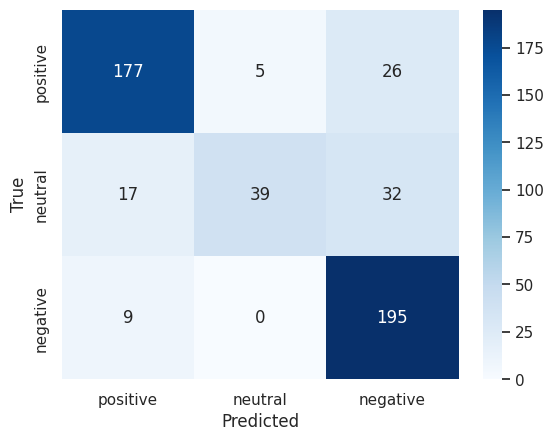

In [ ]:
from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# Train your model on the train dataset and make predictions on the test dataset
df_test_predict=df_test.copy()
df_test_predict.drop(['label'], axis=1, inplace=True)
df_test_predict['label_predict'] = ""
for ind in df_test_predict.index:
  temp_predict = predict(df_test_predict['text'][ind])[0]
  df_test_predict['label_predict'][ind] = temp_predict['label']

pred_labels = df_test_predict['label_predict'].values
true_labels = df_test['label'].values
labels = ["positive", "neutral", "negative"]

# Create the confusion matrix
cm = confusion_matrix(true_labels, pred_labels,labels=labels)

# Visualize the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



> Menghitung Akurasi, Presisi, dan Recall dari model yang sudah di train



In [ ]:
accuracy = sum([cm[i][i] for i in range(len(labels))]) / float(len(true_labels))

precision = []
recall = []
for i in range(len(labels)):
    tp = cm[i][i]
    fp = sum(cm[:, i]) - tp
    fn = sum(cm[i, :]) - tp
    precision.append(tp / float(tp + fp))
    recall.append(tp / float(tp + fn))

In [ ]:
print('Accuracy:', accuracy, "\n")

for i in range(len(labels)):
    print('Precision for class', labels[i], ':', precision[i])
    print('Recall for class', labels[i], ':', recall[i], "\n")

Accuracy: 0.822 

Precision for class positive : 0.8719211822660099
Recall for class positive : 0.8509615384615384 

Precision for class neutral : 0.8863636363636364
Recall for class neutral : 0.4431818181818182 

Precision for class negative : 0.7707509881422925
Recall for class negative : 0.9558823529411765 





> Dalam analisis sentimen biner (mis., mengklasifikasikan ulasan film sebagai positif atau negatif), akurasi 80% atau lebih sering dianggap baik. Namun, untuk tugas yang lebih kompleks yang melibatkan beberapa kategori sentimen (mis., mengklasifikasikan umpan balik pelanggan menjadi positif, negatif, dan netral), ambang akurasi yang baik mungkin lebih rendah.

> Dengan kata lain akurasi model hasil train pada projek ini sebesar 82.2% sudah dapat dianggap sebagai model yang cukup baik dalam melakukan analisis sentimen|






**Implementasi**



In [ ]:
# Mengambil nilai yang reliable saja
dfjogja_filtered = dfjogja[dfjogja['taglist'].isin(listWisata)]
dfjogjawis_filtered = dfjogjawis[dfjogjawis['taglist'].isin(listWisata)]

In [ ]:
dfjogja_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6987 entries, 143 to 451798
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   id         6987 non-null   int64              
 1   likes      6987 non-null   int64              
 2   source     6987 non-null   object             
 3   tweet      6987 non-null   object             
 4   date_time  6987 non-null   datetime64[ns, UTC]
 5   taglist    6987 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2), object(3)
memory usage: 382.1+ KB


In [ ]:
dfjogja_filtered.tail(5)

,id,likes,source,tweet,date_time,taglist
451685,451685,0,Instagram,baru saja mengirim foto air terjun randusari ...,2022-12-07 06:00:00+00:00,[air terjun]
451698,451698,0,Instagram,baru saja mengirim foto air terjun randusari ...,2022-12-07 05:00:00+00:00,[air terjun]
451761,451761,0,FlightAlerts,multi adsbx manoeuvring alert at time wed dec...,2022-12-07 04:00:00+00:00,[gunung]
451776,451776,0,Twitter Web App,nu carelazisnu diy menyalurkan bantuan kepada ...,2022-12-07 04:00:00+00:00,[gunung]
451798,451798,0,Twitter Web App,ingatkan pentingnya menjaga kebersihan babinsa...,2022-12-07 04:00:00+00:00,[taman]


In [ ]:
dfjogjawis_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3204 entries, 4 to 19559
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   id         3204 non-null   int64              
 1   likes      3204 non-null   int64              
 2   source     3204 non-null   object             
 3   tweet      3204 non-null   object             
 4   date_time  3204 non-null   datetime64[ns, UTC]
 5   taglist    3204 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2), object(3)
memory usage: 175.2+ KB


In [ ]:
dfjogjawis_filtered.tail(5)

,id,likes,source,tweet,date_time,taglist
19547,19547,0,OxfordBlue-Twitter,yogyakarta klasterisasi kawasan cagar budaya d...,2022-12-04 13:00:00+00:00,[cagar budaya]
19549,19549,0,dlvr.it,yogyakarta klasterisasi kawasan cagar budaya d...,2022-12-04 13:00:00+00:00,[cagar budaya]
19554,19554,0,Twitter for Android,hari ini anggota batalyon a pelopor satbrimob ...,2022-12-04 10:00:00+00:00,[pantai]
19555,19555,5,Twitter for iPhone,menarik ini buat diangkat jadi wisata budayare...,2022-12-04 05:00:00+00:00,[pantai]
19559,19559,0,Awtoshare,wisata museum affandi yogyakarta,2022-12-03 21:00:00+00:00,[museum]


> implementasi model machine learning

In [ ]:
#Membuat kolom baru dfjogja_filtered
dfjogja_filtered['sentiment'] = ""

for ind in dfjogja_filtered.index:
  temp = predict(dfjogja_filtered['tweet'][ind])[0]
  dfjogja_filtered['sentiment'][ind] = temp['label']

In [ ]:
def clean_tag(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

  
dfjogja_filtered['taglist'].astype(str)
dfjogja_filtered['taglist'] = dfjogja_filtered['taglist'].apply(lambda x:clean_tag(x))

In [ ]:
dfjogja_filtered.sample(10)

,id,likes,source,tweet,date_time,taglist,sentiment
419923,419923,0,Instagram,bukan hanya artefak tapi ia bicara ia menandai...,2022-11-09 12:00:00+00:00,candi,neutral
293184,293184,0,Twitter for Android,collegemenfess nitip kakada yang bisa dimintai...,2022-12-22 11:00:00+00:00,pantai,positive
416161,416161,0,Twitter for Android,pantai selatan yogyakarta,2022-11-13 03:00:00+00:00,pantai,neutral
394479,394479,0,Twitter Web App,heru budi hartono resmi menjabat pj gubernur d...,2022-10-07 11:00:00+00:00,gunung,neutral
349253,349253,0,dlvr.it,menikmati deburan gelombang pantai kukup yogya...,2022-09-24 00:00:00+00:00,pantai,positive
29276,29276,0,Twitter Web App,sempat lari ke jogja pelaku pembunuhan istri s...,2022-07-24 08:00:00+00:00,candi,neutral
151390,151390,0,Twitter for Android,shitlicious mau cari temen yang mau diajak mut...,2022-10-29 13:00:00+00:00,gunung,neutral
342807,342807,1,Twitter Web App,gak rela sampai kelewatan kan kemegahan konser...,2022-09-29 11:00:00+00:00,candi,neutral
247502,247502,0,Twitter for Android,faktasepakbola mirip desain benteng keraton jo...,2022-11-19 08:00:00+00:00,benteng,neutral
311645,311645,1,Twitter Web App,siapa yang mau dapat tiket gratis nonton konse...,2022-07-13 13:00:00+00:00,hutan,positive


In [ ]:
#Membuat kolom baru dfjogjawis_filtered
dfjogjawis_filtered['sentiment'] = ""

for ind in dfjogjawis_filtered.index:
  temp = predict(dfjogjawis_filtered['tweet'][ind])[0]
  dfjogjawis_filtered['sentiment'][ind] = temp['label']

In [ ]:
dfjogjawis_filtered['taglist'].astype(str)
dfjogjawis_filtered['taglist'] = dfjogjawis_filtered['taglist'].apply(lambda x:clean_tag(x))

<ipython-input-83-16dc72d42c61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfjogjawis_filtered['taglist'] = dfjogjawis_filtered['taglist'].apply(lambda x:clean_tag(x))


In [ ]:
dfjogjawis_filtered.sample(10)

,id,likes,source,tweet,date_time,taglist,sentiment
16975,16975,0,Zapier.com,garut pemerintah kabupaten garut jawa barat ...,2022-03-07 14:00:00+00:00,gunung,positive
15319,15319,0,Twitter Web App,jagongan kalurahan sekapanewon rongkopbiro tap...,2022-04-18 04:00:00+00:00,taman,neutral
10013,10013,1,SocialChamp IO,wisata jogja rekomendasi tempat wisata meliha...,2022-09-09 14:00:00+00:00,gunung,positive
11576,11576,0,twittbot.net,wisata alam kebun buah mangunan jogjacitytour...,2022-10-06 11:00:00+00:00,kebun,neutral
6622,6622,0,twittbot.net,wisata alam kebun buah mangunan jogjacitytour...,2022-06-04 02:00:00+00:00,kebun,neutral
14234,14234,0,twittbot.net,wisata alam kebun buah mangunan jogjacitytour...,2022-12-16 23:00:00+00:00,kebun,neutral
1139,1139,0,Awtoshare,tempat wisata pantai sundak gunungkidul jogja,2022-01-01 15:00:00+00:00,pantai,positive
6017,6017,0,twittbot.net,wisata alam kebun buah mangunan jogjacitytour...,2022-06-18 05:00:00+00:00,kebun,neutral
9828,9828,0,twittbot.net,reservasi dan info wisata goa pindul cp to...,2022-09-13 19:00:00+00:00,goa,neutral
14052,14052,0,twittbot.net,wisata alam kebun buah mangunan jogjacitytour...,2022-12-20 02:00:00+00:00,kebun,neutral


In [ ]:
#Membuat kolom baru
dfwisata['sentiment'] = ""

for ind in dfwisata.index:
  temp = predict(dfwisata['tweet'][ind])[0]
  dfwisata['sentiment'][ind] = temp['label']

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
<ipython-input-85-2e461334fe2f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfwisata['sentiment'][ind] = temp['label']


In [ ]:
dfwisata.sample(10)

,id,likes,source,tweet,tag,date_time,sentiment
2651,2652,1,Twitter for Android,kondangan jdi ini pas ke rumah hantu maliobo...,Malioboro,2022-12-20 13:00:00+00:00,positive
21160,21161,0,Twitter for Android,selasa susilawati luhkan kab lombok baratpend...,Taman Sari,2022-08-09 11:00:00+00:00,neutral
12825,12826,0,Twitter for Android,arjibtect beli kembang apa ke pasar,Pasar Kembang,2022-08-26 05:00:00+00:00,positive
6946,6947,6,Twitter for Android,poldadiy poldajogja ditbinmas binmas bisma mal...,Malioboro,2022-11-20 04:00:00+00:00,neutral
24898,24899,0,Twitter for Android,bdngfess taman sari hujan,Taman Sari,2022-04-22 08:00:00+00:00,positive
7742,7743,0,Sunda Empire ✨,daks info kostan di jogja yg sekitaran maliobo...,Malioboro,2022-11-12 08:00:00+00:00,negative
1015,1016,1,Twitter for Android,today partner panaspanasan di posko 💕,Malioboro,2022-12-28 04:00:00+00:00,neutral
23654,23655,47,Twitter for iPhone,eril klo lg di kampus penampilannya ga keliata...,Taman Sari,2022-05-27 16:00:00+00:00,neutral
7282,7283,0,Twitter for Android,video bersama teman lama anies baswedan makan ...,Malioboro,2022-11-17 03:00:00+00:00,neutral
6386,6387,3,Twitter for Android,ryawiedy solo semakin berseri ditangan dingin ...,Malioboro,2022-11-25 14:00:00+00:00,neutral




> Beberapa insight yang dapat dibuat berdasarkan data diatas



1. Most Positive taglist of dfjogja_filtered and dfjogjawis_filtered

In [ ]:
dfjogja_filtered['sentiment_point'] = 0
for ind in dfjogja_filtered.index:
  if dfjogja_filtered['sentiment'][ind] == "positive":
    dfjogja_filtered['sentiment_point'][ind] = 1
  elif dfjogja_filtered['sentiment'][ind] == "negative" :
    dfjogja_filtered['sentiment_point'][ind] = -1

# Create a new dataframe to store the result
sum_of_df = dfjogja_filtered.groupby('taglist').sum()['sentiment_point']
count_of_df = dfjogja_filtered.groupby('taglist').count()['sentiment_point']

# Create a new dataframe to store the result
df_result = pd.DataFrame({
    'value': sum_of_df.index,
    'sentiment_point': sum_of_df.values,
    'count' : count_of_df.values
})

C = df_result['count'].mean()
m = df_result['sentiment_point'].mean()
df_result['BayesianAverage'] = (C*m + df_result['count']*df_result['sentiment_point']) / (C + df_result['count'])

df_sorted = pd.DataFrame(df_result.sort_values(by=['BayesianAverage'], ascending=False))
df_sorted.style.background_gradient(cmap='BuPu')

<ipython-input-160-2457acefe9f7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfjogja_filtered['sentiment_point'] = 0
<ipython-input-160-2457acefe9f7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfjogja_filtered['sentiment_point'][ind] = 1
<ipython-input-160-2457acefe9f7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfjogja_filtered['sentiment_point'][ind] = -1


,value,sentiment_point,count,BayesianAverage
20,pantai,280,1570,246.728245
24,taman,272,1133,229.655444
19,museum,190,726,150.964082
6,candi,101,725,84.713010
10,gunung,51,1374,48.908597
26,taman nasional,0,2,37.095541
1,arung jeram,2,3,36.972407
15,kuil,1,3,36.960528
23,surfing,1,3,36.960528
17,mendaki gunung,0,3,36.948648


In [ ]:
dfjogjawis_filtered['sentiment_point'] = 0
for ind in dfjogjawis_filtered.index:
  if dfjogjawis_filtered['sentiment'][ind] == "positive":
    dfjogjawis_filtered['sentiment_point'][ind] = 1
  elif dfjogjawis_filtered['sentiment'][ind] == "negative" :
    dfjogjawis_filtered['sentiment_point'][ind] = -1

# Create a new dataframe to store the result
sum_of_df = dfjogjawis_filtered.groupby('taglist').sum()['sentiment_point']
count_of_df = dfjogjawis_filtered.groupby('taglist').count()['sentiment_point']

# Create a new dataframe to store the result
df_result = pd.DataFrame({
    'value': sum_of_df.index,
    'sentiment_point': sum_of_df.values,
    'count' : count_of_df.values
})

C = df_result['count'].mean()
m = df_result['sentiment_point'].mean()
df_result['BayesianAverage'] = (C*m + df_result['count']*df_result['sentiment_point']) / (C + df_result['count'])

df_sorted = pd.DataFrame(df_result.sort_values(by=['BayesianAverage'], ascending=False))
df_sorted.style.background_gradient(cmap='BuPu')

<ipython-input-161-ddeac423c010>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfjogjawis_filtered['sentiment_point'] = 0
<ipython-input-161-ddeac423c010>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfjogjawis_filtered['sentiment_point'][ind] = 1
<ipython-input-161-ddeac423c010>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfjogjawis_filtered['sentiment_point'][ind] =

,value,sentiment_point,count,BayesianAverage
19,pantai,143,697,124.688290
22,taman,118,250,87.047262
18,museum,101,145,66.526481
7,candi,73,212,56.030753
11,gunung,61,216,48.808655
0,air terjun,47,76,35.582936
3,bukit,41,131,34.985350
4,cagar alam,1,1,28.874535
9,galeri seni,1,1,28.874535
16,mendaki gunung,1,1,28.874535




> Terlihat bahwa dari kedua dataset tersebut, taglist wisata dengan nilai tertinggi berdasarkan nilai sentimennya menggunakan BayesianAverage memiliki 5 besar yang sama secara berurut yaitu



*   **Pantai**
*   **Taman**
*   **Museum**
*   **Candi**
*   **Gunung**



> Dan beberapa taglist yang cenderung memiliki nilai BayesianAverage yang terbawah adalah

*   **Kebun**
*   **Goa**
*   **Hutan**

2. Most Positive taglist of dfwisata

In [ ]:
dfwisata['sentiment_point'] = 0
for ind in dfwisata.index:
  if dfwisata['sentiment'][ind] == "positive":
    dfwisata['sentiment_point'][ind] = 1
  elif dfwisata['sentiment'][ind] == "negative" :
    dfwisata['sentiment_point'][ind] = -1

# Create a new dataframe to store the result
sum_of_df = dfwisata.groupby('tag').sum()['sentiment_point']
count_of_df = dfwisata.groupby('tag').count()['sentiment_point']

# Create a new dataframe to store the result
df_result = pd.DataFrame({
    'value': sum_of_df.index,
    'sentiment_point': sum_of_df.values,
    'count' : count_of_df.values
})

C = df_result['count'].mean()
m = df_result['sentiment_point'].mean()
df_result['BayesianAverage'] = (C*m + df_result['count']*df_result['sentiment_point']) / (C + df_result['count'])

df_sorted = pd.DataFrame(df_result.sort_values(by=['BayesianAverage'], ascending=False))
df_sorted.style.background_gradient(cmap='BuPu')

<ipython-input-162-65fd874788a2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfwisata['sentiment_point'][ind] = 1
<ipython-input-162-65fd874788a2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfwisata['sentiment_point'][ind] = -1


,value,sentiment_point,count,BayesianAverage
27,Pasar Kembang,534,3273,416.933097
31,Taman Sari,348,9798,318.284384
8,Gembira Loka,231,1953,158.314415
26,Museum Sonobudoyo,199,658,85.902114
10,Jogja National Museum,110,558,44.999752
24,Museum Sandi,106,445,38.376213
34,Wisata Rejowinangun,121,201,26.481002
17,Museum Benteng Vredeburg,70,358,23.832358
30,Situs Warungboto,18,110,7.365374
23,Museum Perjuangan Yogyakarta,13,18,6.241546




> Terlihat bahwa tag wisata dengan **nilai tertinggi** berdasarkan nilai sentimennya menggunakan BayesianAverage adalah

*   **Pasar kembang**
*   **Taman Sari**
*   **Gembira Loka**
*   **Museum Sonobudoyo**
*   **Museum Nasional Yogyakarta**
*   **Museum Sandi**
*   **Wisata Rejowinangun**
*   **Museum Benteng Vredeburg** 

> Dan beberapa taglist yang cenderung memiliki nilai BayesianAverage yang **terbawah** adalah

*   **Tugu Jam Jogja**	
*   **Masjid Gedhe Kauman**
*   **Artjog**
*   **Malioboro**

3. Tweets terpositif terkait wisata kota jogja dengan likes terbanyak 

In [ ]:
# calculate the total likes of each tag value
dflikes_sum = dfwisata.loc[dfwisata['sentiment'] == 'positive'].groupby(["tag"]).sum()
dflikes_sum['likes'] = dflikes_sum.groupby(["tag"]).mean()['likes']
dflikes_sum.drop(['id'], axis=1, inplace=True)
dflikes_sum = dflikes_sum.sort_values('likes', ascending=False)
# Select the top 10 tags by likes
dflikes_sum= dflikes_sum.nlargest(10, 'likes')


# calculate the mean of likes of each tag value
dflikes_mean = dfwisata.loc[dfwisata['sentiment'] == 'positive'].groupby(["tag"]).mean()
dflikes_mean['likes'] = dflikes_mean.groupby(["tag"]).mean()['likes']
dflikes_mean.drop(['id'], axis=1, inplace=True)
dflikes_mean = dflikes_mean.sort_values('likes', ascending=False)
# Select the top 10 tags by likes
dflikes_mean= dflikes_mean.nlargest(10, 'likes')

<ipython-input-154-a9b151af0874>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(dflikes_sum.index, rotation=90)
<ipython-input-154-a9b151af0874>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(dflikes_mean.index, rotation=90)


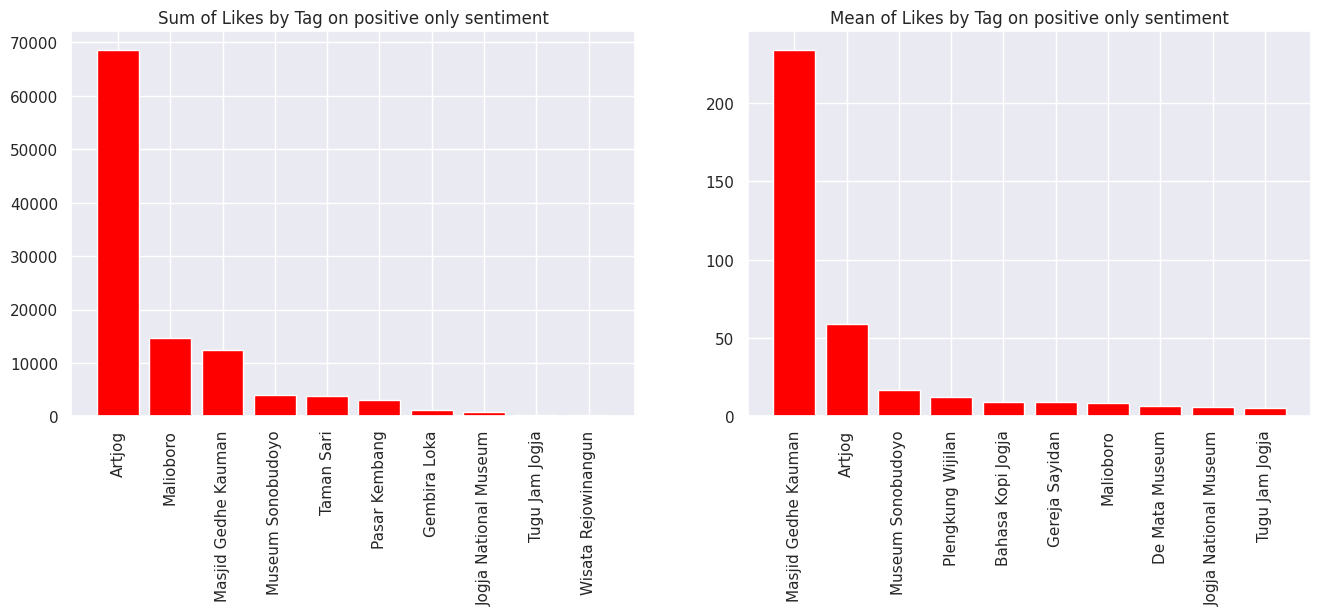

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Create a bar plot of the total likes
axs[0].bar(dflikes_sum.index, dflikes_sum['likes'], color='red')
axs[0].set_title('Sum of Likes by Tag on positive only sentiment')
axs[0].set_xticklabels(dflikes_sum.index, rotation=90)


# Create a bar plot of the mean of likes
axs[1].bar(dflikes_mean.index, dflikes_mean['likes'], color='red')
axs[1].set_title('Mean of Likes by Tag on positive only sentiment')
axs[1].set_xticklabels(dflikes_mean.index, rotation=90)

# adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.2)

# show the plot
plt.show()

In [ ]:
# calculate the total likes of each tag value
dflikes_sum = dfwisata.loc[dfwisata['sentiment'] == 'negative'].groupby(["tag"]).sum()
dflikes_sum['likes'] = dflikes_sum.groupby(["tag"]).mean()['likes']
dflikes_sum.drop(['id'], axis=1, inplace=True)
dflikes_sum = dflikes_sum.sort_values('likes', ascending=False)
# Select the top 10 tags by likes
dflikes_sum= dflikes_sum.nlargest(10, 'likes')


# calculate the mean of likes of each tag value
dflikes_mean = dfwisata.loc[dfwisata['sentiment'] == 'negative'].groupby(["tag"]).mean()
dflikes_mean['likes'] = dflikes_mean.groupby(["tag"]).mean()['likes']
dflikes_mean.drop(['id'], axis=1, inplace=True)
dflikes_mean = dflikes_mean.sort_values('likes', ascending=False)
# Select the top 10 tags by likes
dflikes_mean= dflikes_mean.nlargest(10, 'likes')

<ipython-input-156-8121a304cb3e>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(dflikes_sum.index, rotation=90)
<ipython-input-156-8121a304cb3e>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(dflikes_mean.index, rotation=90)


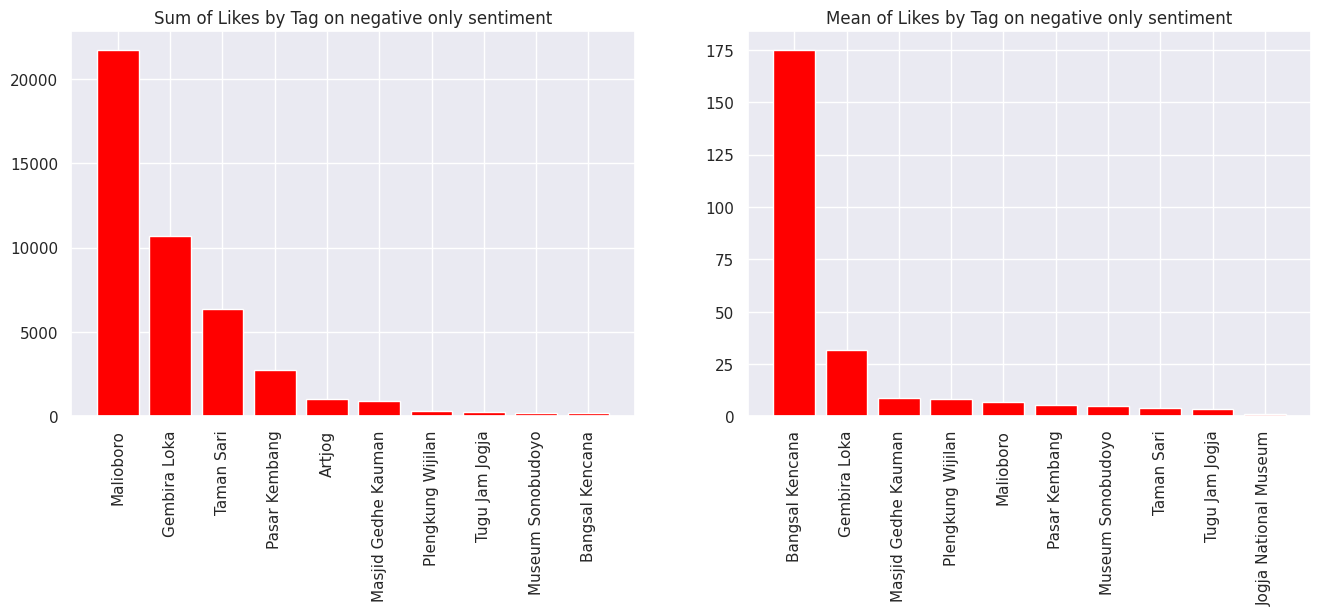

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Create a bar plot of the total likes
axs[0].bar(dflikes_sum.index, dflikes_sum['likes'], color='red')
axs[0].set_title('Sum of Likes by Tag on negative only sentiment')
axs[0].set_xticklabels(dflikes_sum.index, rotation=90)


# Create a bar plot of the mean of likes
axs[1].bar(dflikes_mean.index, dflikes_mean['likes'], color='red')
axs[1].set_title('Mean of Likes by Tag on negative only sentiment')
axs[1].set_xticklabels(dflikes_mean.index, rotation=90)

# adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.2)

# show the plot
plt.show()



> Beberapa analisis dari hasil diatas :



*   Terlihat bahwa **Artjog** adalah salah satu wisata paling positif di kota jogja dengan menempati **urutan kedua untuk rata-rata likes dari tweets yang bersentimen positif**, dan disisi lain bahkan tidak muncul dalam urutan 10 besar untuk rata-rata likes dari tweets yang bersentimen negatif
*   **Bangsal kencana** di sisi lain merupakan wisata dengan **tweets negatif dengan jumlah rata-rata likes yang terbanyak**
*   **Museum Sonoboyo**, **Masjid Gedhe Kauman** dan **Malioboro** merupakan salah satu yang **bervariasi** dimana rata-rata likes pada tweets yang bersentimen positif dan negatif cukup banyak. Tetapi **Museum Sonoboyo** dan **Masjid Gedhe Kauman** masih lebih cenderung **positif** sedangkan **Malioboro** masih lebih cenderung **negatif**


*   Daftar tag wisata dengan rata-rata likes yang banyak pada sentimen positif saja : **Gereja Sayidan**, **De Mata Museum**
*   Daftar tag wisata dengan rata-rata likes yang banyak pada sentimen negatif saja : **Gembira Loka**, **Taman Sari**, **Museum Nasional Yogyakarta**

